In [1]:
import numpy
import sympy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.viz import GraphicalModel
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json

In [2]:
p = lambda: Concept(name='p')
r = lambda: Concept(name='r')

t2 = NaturalDegradation(subject=r())
t2.set_mass_action_rate_law('V')
t3 = ControlledProduction(controller=r(), outcome=p())
t3.set_mass_action_rate_law('L')
t4 = NaturalDegradation(subject=p())
t4.set_mass_action_rate_law('U')

params = {'V': Parameter(name='V', value=0.03),
          'L': Parameter(name='L', value=2),
          'U': Parameter(name='U', value=0.15)}

initials = {
    'p': Initial(concept=p(), expression=sympy.Float(100)),
    'r': Initial(concept=r(), expression=sympy.Float(3))
}
    

tm = TemplateModel(
    templates=[t2, t3, t4],
    parameters=params,
    initials=initials
    )

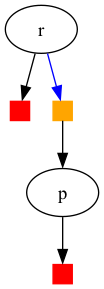

In [3]:
GraphicalModel.for_jupyter(tm)

In [4]:
chen_tm = stratify(tm,
                   key='species',
                   strata=['1', '2', '3'],
                   structure=[],
                   cartesian_control=False)

for i in range(1, 4):
    t = ControlledProduction(controller=Concept(name='p_1', context={'species': '1'}),
                             outcome=Concept(name=f'r_{i}', context={'species': i}))
    t.set_mass_action_rate_law(f'C_{i-1}')
    chen_tm.parameters[f'C_{i-1}'] = Parameter(name=f'C_{i-1}', value=0.03)
    chen_tm.templates.append(t)

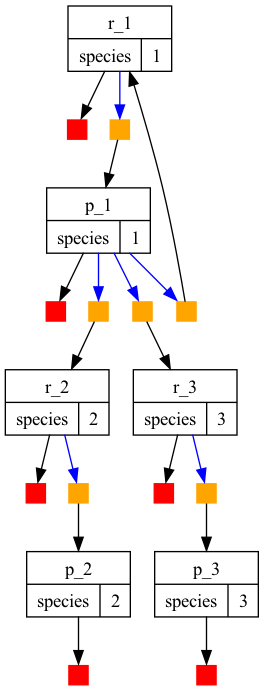

In [5]:
GraphicalModel.for_jupyter(chen_tm)

In [6]:
params = {
    'V': [0.03, 0.03, 0.03],
    'U': [0.15, 0.15, 0.015],
    'C': [0.03, 0.03, 0.024],
}
inits = {
    'r': [3, 6, 5],
    'p': [100, 500, 1],
}
for k, v in params.items():
    for idx, val in enumerate(v):
        chen_tm.parameters[f'{k}_{idx}'].value = val
for k, v in inits.items():
    for idx, val in enumerate(v):
        chen_tm.initials[f'{k}_{idx + 1}'].expression = SympyExprStr(sympy.Float(val))

In [7]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}
models = {'chen': chen_tm}

for mkey, model in models.items():
    for fkey, fun in frameworks.items():
        with open(f'scenario6_{mkey}_{fkey}.json', 'w') as fh:
            json.dump(fun(model), fh, indent=1)

In [8]:
om = OdeModel(Model(chen_tm), initialized=True)

In [9]:
ts = numpy.linspace(0, 10*60, 100)
res = simulate_ode_model(om, times=ts)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Proportion')

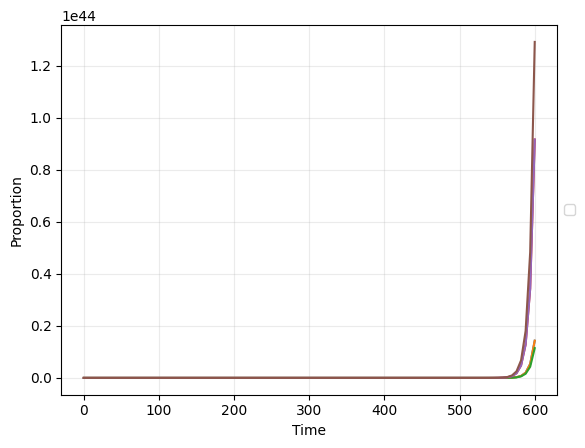

In [10]:
plt.plot(ts, res)#, label=range(1,7))
#plt.ylim([0, 1.25])
plt.grid(alpha=0.25)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Proportion')

In [11]:
om.kinetics

Matrix([
[ -0.03*y[0, 0] + 0.03*y[3, 0]],
[ -0.03*y[1, 0] + 0.03*y[3, 0]],
[-0.03*y[2, 0] + 0.024*y[3, 0]],
[   2.0*y[0, 0] - 0.15*y[3, 0]],
[   2.0*y[1, 0] - 0.15*y[4, 0]],
[  2.0*y[2, 0] - 0.015*y[5, 0]]])